# Generating Graph from the SMILES representation

In [1]:
import numpy as np
import pandas as pd

from torch_geometric.data import Data
import torch

from rdkit import Chem
from rdkit.Chem import AllChem


/home/lonewolf/anaconda3/lib/python3.11/site-packages/torch/__config__.py:10: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._show_config()


In [2]:
df = pd.read_csv("dataset/GDSC_SMILES_merged.csv")
df = df.dropna(subset=["SMILES"])
drug_smiles = dict(zip(df["DRUG_NAME"], df["SMILES"]))

In [3]:
drug_smiles

{'Camptothecin': 'CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3=C2)O',
 'Vinblastine': 'CCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC9)(C(C(C8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC)O\nCCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC9)(C(C(C8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC)O\nCCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC9)(C(C(C8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC)O\nCCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC9)(C(C(C8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC)O\nCCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC9)(C(C(C8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC)O\nCCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC9)(C(C(C8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC)O\nCCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC9)(C(C(C8N6C)(C(=O)OC)O)OC(=O)C)CC)OC)C(=O)OC)O\nCCC1(CC2CC(C3=C(CCN(C2)C1)C4=CC=CC=C4N3)(C5=C(C=C6C(=C5)C78CCN9C7C(C=CC

In [4]:
def smiles_to_mol(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        Chem.Kekulize(mol)
    return mol

In [5]:
def build_atom_vocab(smiles_dict):
    atom_set = set()
    for smi in smiles_dict.values():
        mol = Chem.MolFromSmiles(smi)
        if mol:
            for atom in mol.GetAtoms():
                atom_set.add(atom.GetSymbol())
    return sorted(atom_set)

In [6]:
atom_vocab = build_atom_vocab(drug_smiles)
atom_vocab

['B', 'Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'Pt', 'S']

In [7]:
from rdkit import Chem

# Define vocabularies
# ATOM_LIST = ['C', 'N', 'O', 'S', 'F', 'P', 'Cl', 'Br', 'I', 'H', 'B', 'Si', 'Na', 'K', 'Li', 'Mg', 'Ca', 'Fe', 'Zn', 'Se', 'Cu']
ATOM_LIST = atom_vocab
DEGREE_LIST = [0, 1, 2, 3, 4, 5]
NUM_H_LIST = [0, 1, 2, 3, 4]
VALENCE_LIST = [0, 1, 2, 3, 4, 5, 6]

def one_hot_encoding(x, allowable_set):
    return [int(x == s) for s in allowable_set]

def atom_features(atom):
    return one_hot_encoding(atom.GetSymbol(), ATOM_LIST) + \
           one_hot_encoding(atom.GetDegree(), DEGREE_LIST) + \
           one_hot_encoding(atom.GetTotalNumHs(), NUM_H_LIST) + \
           one_hot_encoding(atom.GetImplicitValence(), VALENCE_LIST) + \
           [int(atom.GetIsAromatic())]

def mol_to_graph_data_obj(mol):
    atoms = mol.GetAtoms()
    x = torch.tensor([atom_features(atom) for atom in atoms], dtype=torch.float)

    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # undirected graph

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    return Data(x=x, edge_index=edge_index)


In [8]:
from torch_geometric.data import InMemoryDataset

class DrugGraphDataset(InMemoryDataset):
    def __init__(self, smiles_dict):
        self.smiles_dict = smiles_dict
        super().__init__('.', transform=None, pre_transform=None)
        self.data, self.slices = self._process()

    def _process(self):
        data_list = []
        for name, smi in self.smiles_dict.items():
            mol = smiles_to_mol(smi)
            if mol:
                data = mol_to_graph_data_obj(mol)
                data.drug_name = name
                data_list.append(data)
        return self.collate(data_list)


In [9]:
dataset = DrugGraphDataset(drug_smiles)
print(dataset[0])

Data(x=[26, 30], edge_index=[2, 60], drug_name='Camptothecin')


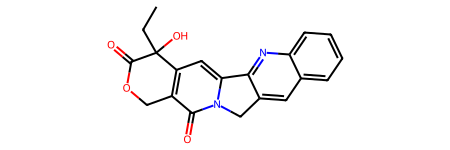

In [10]:
mol2 = smiles_to_mol(drug_smiles["Camptothecin"])
mol2

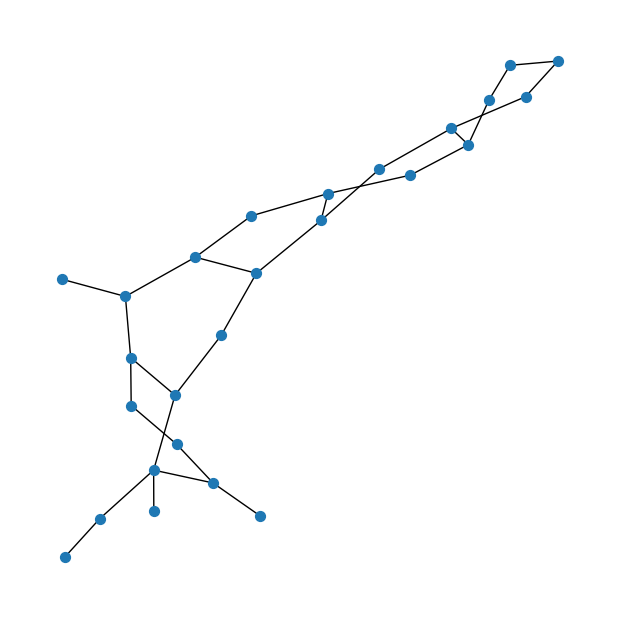

In [11]:
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
import networkx as nx

G = to_networkx(dataset[0], to_undirected=True)
plt.figure(figsize=(6,6))
nx.draw(G, node_size=50)
plt.show()


In [12]:
print(dataset[0].x.shape)
print(dataset[0].edge_index.shape)

torch.Size([26, 30])
torch.Size([2, 60])


In [13]:
print(len(dataset[0].x[0]))
print(len(dataset[0].edge_index[0]))

30
60


In [14]:
print(dataset[100])

Data(x=[39, 30], edge_index=[2, 86], drug_name='Epirubicin')


# Creating the layers

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_max_pool
from torch_geometric.data import Data

In [16]:
class DrugGINEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, out_dim=128):
        super().__init__()

        # MLPs for GIN layers
        self.mlp1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.gin1 = GINConv(self.mlp1)

        self.mlp2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.gin2 = GINConv(self.mlp2)

        self.fc = nn.Linear(hidden_dim, out_dim)  # Final output: 128-dim

    def forward(self, x, edge_index, batch):
        x = self.gin1(x, edge_index)
        x = F.relu(x)
        x = self.gin2(x, edge_index)
        x = F.relu(x)

        # Global pooling to get graph-level embedding
        x = global_max_pool(x, batch)

        # Final FC layer
        x = self.fc(x)
        return x

In [17]:
class CellLineEncoder(nn.Module):
    def __init__(self, input_dim=658):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 1024)
        self.dropout = nn.Dropout(0.2)
        self.fc3 = nn.Linear(1024, 128)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x


In [18]:
# Load merged GDSC dataset with drug, cell line, IC50, and SMILES
df = pd.read_csv("dataset/GDSC_SMILES_merged.csv", index_col=0)
df = df.dropna(subset=["SMILES"])

# Load GSVA matrix (rows = cell line, cols = pathways OR vice versa)
gsva_df = pd.read_csv("dataset/ccle_gsva_scores.csv", index_col=0)


In [19]:
df

,DRUG_ID,DRUG_NAME,CELL_LINE_NAME,LN_IC50,SMILES
0,1003,Camptothecin,PFSK-1,-1.462148,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
1,1003,Camptothecin,A673,-4.869447,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
2,1003,Camptothecin,ES5,-3.360684,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
3,1003,Camptothecin,ES7,-5.045014,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
4,1003,Camptothecin,EW-11,-3.741620,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...
...,...,...,...,...,...
242031,2499,N-acetyl cysteine,SNU-175,10.134495,CC(=O)NC(CS)C(=O)O
242032,2499,N-acetyl cysteine,SNU-407,8.575555,CC(=O)NC(CS)C(=O)O
242033,2499,N-acetyl cysteine,SNU-61,10.520666,CC(=O)NC(CS)C(=O)O
242034,2499,N-acetyl cysteine,SNU-C5,10.701430,CC(=O)NC(CS)C(=O)O


In [20]:
cell_lines_available = set(gsva_df.columns)
cell_lines_available

{'U2OS_BONE',
 'BICR6_UPPER_AERODIGESTIVE_TRACT',
 'CORL88_LUNG',
 'RCM1_LARGE_INTESTINE',
 'KMS11_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'TTC642_SOFT_TISSUE',
 'BCP1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'HEC265_ENDOMETRIUM',
 'HEP3B217_LIVER',
 'KMS18_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'EOL1_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'HUH6_LIVER',
 'NCIH2171_LUNG',
 'HS616T_FIBROBLAST',
 'SNU81_LARGE_INTESTINE',
 'NCIH2126_LUNG',
 'DB_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'NCIH441_LUNG',
 'TE617T_SOFT_TISSUE',
 'UMUC1_URINARY_TRACT',
 'BC3C_URINARY_TRACT',
 'INA6_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'KELLY_AUTONOMIC_GANGLIA',
 'AU565_BREAST',
 'CORL24_LUNG',
 'OCIMY7_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'AN3CA_ENDOMETRIUM',
 'JVM3_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'SNU46_UPPER_AERODIGESTIVE_TRACT',
 'COV362_OVARY',
 'CADOES1_BONE',
 'NCIH1651_LUNG',
 'NH6_AUTONOMIC_GANGLIA',
 'CALU6_LUNG',
 'KYSE180_OESOPHAGUS',
 'NCIH446_LUNG',
 'RPMI8402_HAEMATOPOIETIC_AND_LYMPHOID_TISSUE',
 'CO

In [21]:
# Normalize IC50 if needed
df["LN_IC50"] = df["LN_IC50"].astype(float)
df["IC50_NORMALIZED"] = 1 / (1 + (1/(np.exp(df["LN_IC50"])**0.1)) )

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199501 entries, 0 to 242035
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   DRUG_ID          199501 non-null  int64  
 1   DRUG_NAME        199501 non-null  object 
 2   CELL_LINE_NAME   199501 non-null  object 
 3   LN_IC50          199501 non-null  float64
 4   SMILES           199501 non-null  object 
 5   IC50_NORMALIZED  199501 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 10.7+ MB


In [23]:
df.describe()

,DRUG_ID,LN_IC50,IC50_NORMALIZED
count,199501.000000,199501.000000,199501.000000
mean,1542.707836,2.707180,0.566360
std,406.596728,2.823073,0.068694
min,1003.000000,-8.769011,0.293820
25%,1083.000000,1.353548,0.533787
50%,1583.000000,3.171952,0.578641
75%,1912.000000,4.656668,0.614358
max,2499.000000,13.107465,0.787638


In [24]:
df

,DRUG_ID,DRUG_NAME,CELL_LINE_NAME,LN_IC50,SMILES,IC50_NORMALIZED
0,1003,Camptothecin,PFSK-1,-1.462148,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.463511
1,1003,Camptothecin,A673,-4.869447,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.380614
2,1003,Camptothecin,ES5,-3.360684,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.416765
3,1003,Camptothecin,ES7,-5.045014,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.376483
4,1003,Camptothecin,EW-11,-3.741620,CCC1(C2=C(COC1=O)C(=O)N3CC4=CC5=CC=CC=C5N=C4C3...,0.407536
...,...,...,...,...,...,...
242031,2499,N-acetyl cysteine,SNU-175,10.134495,CC(=O)NC(CS)C(=O)O,0.733695
242032,2499,N-acetyl cysteine,SNU-407,8.575555,CC(=O)NC(CS)C(=O)O,0.702150
242033,2499,N-acetyl cysteine,SNU-61,10.520666,CC(=O)NC(CS)C(=O)O,0.741172
242034,2499,N-acetyl cysteine,SNU-C5,10.701430,CC(=O)NC(CS)C(=O)O,0.744624


In [25]:
cell_lines_obs = set(df["CELL_LINE_NAME"].unique())
cell_lines_obs

{'22RV1',
 '23132-87',
 '42-MG-BA',
 '451Lu',
 '5637',
 '639-V',
 '647-V',
 '697',
 '769-P',
 '786-0',
 '8-MG-BA',
 '8305C',
 '8505C',
 'A101D',
 'A172',
 'A204',
 'A2058',
 'A253',
 'A2780',
 'A3-KAW',
 'A375',
 'A388',
 'A4-Fuk',
 'A427',
 'A431',
 'A498',
 'A549',
 'A673',
 'A704',
 'ABC-1',
 'ACHN',
 'AGS',
 'ALL-PO',
 'ALL-SIL',
 'AM-38',
 'AMO-1',
 'AN3-CA',
 'ARH-77',
 'ASH-3',
 'ATN-1',
 'AU565',
 'AsPC-1',
 'B-CPAP',
 'BALL-1',
 'BB30-HNC',
 'BB49-HNC',
 'BB65-RCC',
 'BC-1',
 'BC-3',
 'BE-13',
 'BE2-M17',
 'BEN',
 'BFTC-905',
 'BFTC-909',
 'BHT-101',
 'BHY',
 'BICR10',
 'BICR22',
 'BICR31',
 'BICR78',
 'BL-41',
 'BONNA-12',
 'BPH-1',
 'BT-20',
 'BT-474',
 'BT-483',
 'BT-549',
 'BV-173',
 'Becker',
 'BxPC-3',
 'C-33-A',
 'C-4-I',
 'C2BBe1',
 'C32',
 'C3A',
 'CA46',
 'CADO-ES1',
 'CAKI-1',
 'CAL-120',
 'CAL-12T',
 'CAL-148',
 'CAL-27',
 'CAL-29',
 'CAL-33',
 'CAL-39',
 'CAL-51',
 'CAL-54',
 'CAL-62',
 'CAL-72',
 'CAL-78',
 'CAL-85-1',
 'CAMA-1',
 'CAPAN-1',
 'CAPAN-2',
 'CAS-1',

In [26]:
# # Filter for valid rows only
# df = df[df["CELL_LINE_NAME"].isin(cell_lines_available)]
# df

In [27]:
print("GDSC df cell lines:", df["CELL_LINE_NAME"].unique()[:5])
print("GSVA df index:", gsva_df.columns[:5])

GDSC df cell lines: ['PFSK-1' 'A673' 'ES5' 'ES7' 'EW-11']
GSVA df index: Index(['X22RV1_PROSTATE', 'X2313287_STOMACH', 'X253JBV_URINARY_TRACT',
       'X253J_URINARY_TRACT', 'X42MGBA_CENTRAL_NERVOUS_SYSTEM'],
      dtype='object')


In [37]:
# Normalize GDSC
df["CELL_LINE_NAME"] = df["CELL_LINE_NAME"].str.strip().str.upper()
cell_lines_obs = set(df["CELL_LINE_NAME"].unique())

# Normalize GSVA
gsva_df.columns = gsva_df.columns.str.strip().str.upper()
cell_lines_available = set(gsva_df.columns.str.split("_").str[0].str.upper())

In [38]:
common_cell_lines = cell_lines_obs.intersection(cell_lines_available)
print("Now common cell lines:", len(common_cell_lines))


Now common cell lines: 133


In [39]:
cell_lines_obs

{'22RV1',
 '23132-87',
 '42-MG-BA',
 '451LU',
 '5637',
 '639-V',
 '647-V',
 '697',
 '769-P',
 '786-0',
 '8-MG-BA',
 '8305C',
 '8505C',
 'A101D',
 'A172',
 'A204',
 'A2058',
 'A253',
 'A2780',
 'A3-KAW',
 'A375',
 'A388',
 'A4-FUK',
 'A427',
 'A431',
 'A498',
 'A549',
 'A673',
 'A704',
 'ABC-1',
 'ACHN',
 'AGS',
 'ALL-PO',
 'ALL-SIL',
 'AM-38',
 'AMO-1',
 'AN3-CA',
 'ARH-77',
 'ASH-3',
 'ASPC-1',
 'ATN-1',
 'AU565',
 'B-CPAP',
 'BALL-1',
 'BB30-HNC',
 'BB49-HNC',
 'BB65-RCC',
 'BC-1',
 'BC-3',
 'BE-13',
 'BE2-M17',
 'BECKER',
 'BEN',
 'BFTC-905',
 'BFTC-909',
 'BHT-101',
 'BHY',
 'BICR10',
 'BICR22',
 'BICR31',
 'BICR78',
 'BL-41',
 'BONNA-12',
 'BPH-1',
 'BT-20',
 'BT-474',
 'BT-483',
 'BT-549',
 'BV-173',
 'BXPC-3',
 'C-33-A',
 'C-4-I',
 'C2BBE1',
 'C32',
 'C3A',
 'CA-SKI',
 'CA46',
 'CA9-22',
 'CADO-ES1',
 'CAKI-1',
 'CAL-120',
 'CAL-12T',
 'CAL-148',
 'CAL-27',
 'CAL-29',
 'CAL-33',
 'CAL-39',
 'CAL-51',
 'CAL-54',
 'CAL-62',
 'CAL-72',
 'CAL-78',
 'CAL-85-1',
 'CALU-3',
 'CALU-6',


In [41]:
sorted(cell_lines_available)

['A101D',
 'A1207',
 'A172',
 'A204',
 'A2058',
 'A253',
 'A2780',
 'A375',
 'A3KAW',
 'A427',
 'A498',
 'A4FUK',
 'A549',
 'A673',
 'A704',
 'ABC1',
 'ACCMESO1',
 'ACHN',
 'AGS',
 'ALLSIL',
 'AM38',
 'AML193',
 'AMO1',
 'AN3CA',
 'ASPC1',
 'AU565',
 'BC3C',
 'BCP1',
 'BCPAP',
 'BDCM',
 'BEN',
 'BFTC905',
 'BFTC909',
 'BHT101',
 'BHY',
 'BICR16',
 'BICR18',
 'BICR22',
 'BICR31',
 'BICR56',
 'BICR6',
 'BL41',
 'BL70',
 'BT12',
 'BT20',
 'BT474',
 'BT483',
 'BT549',
 'BV173',
 'BXPC3',
 'C2BBE1',
 'C32',
 'C8166',
 'CA46',
 'CACO2',
 'CADOES1',
 'CAKI1',
 'CAKI2',
 'CAL120',
 'CAL12T',
 'CAL148',
 'CAL27',
 'CAL29',
 'CAL33',
 'CAL51',
 'CAL54',
 'CAL62',
 'CAL78',
 'CAL851',
 'CALU1',
 'CALU3',
 'CALU6',
 'CAMA1',
 'CAOV3',
 'CAOV4',
 'CAPAN1',
 'CAPAN2',
 'CAS1',
 'CCFSTTG1',
 'CCK81',
 'CFPAC1',
 'CH157MN',
 'CHAGOK1',
 'CHP126',
 'CHP212',
 'CI1',
 'CJM',
 'CL11',
 'CL14',
 'CL34',
 'CL40',
 'CMK',
 'CMLT1',
 'COLO201',
 'COLO320',
 'COLO668',
 'COLO678',
 'COLO679',
 'COLO680N',
 'C